In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Linear Regression Model").getOrCreate()

In [2]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString, StringIndexer

In [3]:
data = spark.read.csv('sbbni.csv',header = True, inferSchema = True)

In [4]:
data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Value: long (nullable = true)
 |-- Frequency: integer (nullable = true)



In [5]:
data.head(3)

[Row(Date=datetime.date(2023, 12, 29), Open=5750, High=5750, Low=5675, Close=5725, Volume=93126000, Value=532734332500, Frequency=11571),
 Row(Date=datetime.date(2023, 12, 28), Open=5700, High=5750, Low=5675, Close=5725, Volume=121434600, Value=694709195000, Frequency=13678),
 Row(Date=datetime.date(2023, 12, 27), Open=5700, High=5725, Low=5625, Close=5625, Volume=131368000, Value=746392540000, Frequency=17906)]

In [6]:
for item in data.head(1)[0]:
    print(item)

2023-12-29
5750
5750
5675
5725
93126000
532734332500
11571


In [7]:
data.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value', 'Frequency']

In [8]:
data.groupBy('Close').count().show()

+-----+-----+
|Close|count|
+-----+-----+
| 5300|    5|
| 4900|    2|
| 4190|    5|
| 2580|    1|
| 3490|    1|
| 3220|    1|
| 4000|    2|
| 5100|    5|
| 5375|    6|
| 4230|    5|
| 2240|    1|
| 4700|    3|
| 2610|    1|
| 4830|    4|
| 3010|    2|
| 4610|   10|
| 4200|   11|
| 4240|    3|
| 3990|    4|
| 3500|    1|
+-----+-----+
only showing top 20 rows



In [9]:
indexer_volume = StringIndexer(inputCol='Volume', outputCol='VolumeIndex')
indexer_value = StringIndexer(inputCol='Value', outputCol='ValueIndex')

In [10]:
indexed = indexer_volume.fit(data).transform(data)
indexed = indexer_value.fit(indexed).transform(indexed)

In [11]:
indexed.show()

+----------+----+----+----+-----+---------+-------------+---------+-----------+----------+
|      Date|Open|High| Low|Close|   Volume|        Value|Frequency|VolumeIndex|ValueIndex|
+----------+----+----+----+-----+---------+-------------+---------+-----------+----------+
|2023-12-29|5750|5750|5675| 5725| 93126000| 532734332500|    11571|      923.0|     538.0|
|2023-12-28|5700|5750|5675| 5725|121434600| 694709195000|    13678|      153.0|     758.0|
|2023-12-27|5700|5725|5625| 5625|131368000| 746392540000|    17906|      209.0|     812.0|
|2023-12-22|5650|5700|5600| 5675|109411300| 619209565000|    14811|       75.0|     659.0|
|2023-12-21|5550|5600|5525| 5575| 99049600| 550408390000|     9607|      969.0|     561.0|
|2023-12-20|5700|5700|5550| 5550|138470900| 777000642500|    15676|      256.0|     837.0|
|2023-12-19|5450|5550|5450| 5550|158893700| 877220682500|    12854|      358.0|     904.0|
|2023-12-18|5575|5575|5500| 5500|102780900| 567993982500|    12296|       15.0|     589.0|

In [12]:
indexed.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Value: long (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- VolumeIndex: double (nullable = false)
 |-- ValueIndex: double (nullable = false)



In [13]:
assembler = VectorAssembler(inputCols =['Open', 'High', 'Low', 'Close','Frequency'],
                            outputCol='features')

In [14]:
output = assembler.transform(data)

In [15]:
output.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Value: long (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
print(output.features)

Column<'features'>


In [17]:
output.head(1)

[Row(Date=datetime.date(2023, 12, 29), Open=5750, High=5750, Low=5675, Close=5725, Volume=93126000, Value=532734332500, Frequency=11571, features=DenseVector([5750.0, 5750.0, 5675.0, 5725.0, 11571.0]))]

In [18]:
final_data = output.select('features','Close')

In [19]:
final_data.show()

+--------------------+-----+
|            features|Close|
+--------------------+-----+
|[5750.0,5750.0,56...| 5725|
|[5700.0,5750.0,56...| 5725|
|[5700.0,5725.0,56...| 5625|
|[5650.0,5700.0,56...| 5675|
|[5550.0,5600.0,55...| 5575|
|[5700.0,5700.0,55...| 5550|
|[5450.0,5550.0,54...| 5550|
|[5575.0,5575.0,55...| 5500|
|[5575.0,5600.0,55...| 5550|
|[5450.0,5550.0,54...| 5550|
|[5300.0,5350.0,52...| 5300|
|[5375.0,5400.0,53...| 5325|
|[5325.0,5375.0,53...| 5300|
|[5425.0,5450.0,53...| 5375|
|[5400.0,5475.0,54...| 5475|
|[5425.0,5450.0,54...| 5425|
|[5425.0,5500.0,54...| 5450|
|[5450.0,5575.0,54...| 5500|
|[5275.0,5375.0,52...| 5350|
|[5375.0,5375.0,52...| 5275|
+--------------------+-----+
only showing top 20 rows



In [20]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [21]:
train_data.describe().show()

+-------+------------------+
|summary|             Close|
+-------+------------------+
|  count|               694|
|   mean|4344.6037463976945|
| stddev|  721.100365703278|
|    min|              2170|
|    max|              5725|
+-------+------------------+



In [22]:
test_data.describe().show()

+-------+-----------------+
|summary|            Close|
+-------+-----------------+
|  count|              281|
|   mean|4335.996441281139|
| stddev|751.1041182258705|
|    min|             2240|
|    max|             5725|
+-------+-----------------+



In [23]:
regressor = LinearRegression(labelCol='Close')

In [24]:
model = regressor.fit(train_data)

In [25]:
pred_data = model.evaluate(test_data)

In [26]:
pred_data.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|-1.44154910231009...|
|2.910383045673370...|
|7.912603905424476...|
|-3.63797880709171...|
|3.637978807091713...|
|5.593392415903508...|
|6.320988177321851...|
|1.045918907038867...|
|-7.23048287909478...|
|3.54702933691442E-11|
|5.456968210637569...|
|5.32054400537163E-11|
|2.273736754432320...|
|-1.30967237055301...|
|1.273292582482099...|
|-1.18234311230480...|
|1.655280357226729...|
|4.411049303598702...|
|-8.00355337560176...|
|8.549250196665525...|
+--------------------+
only showing top 20 rows



In [27]:
pred_data.rootMeanSquaredError

6.12017071982746e-11

In [28]:
pred_data.r2

1.0

In [29]:
pred_data.meanSquaredError

3.7456489639833366e-21

In [30]:
pred_data.meanAbsoluteError

4.5154308129658796e-11

In [31]:
from pyspark.sql import functions as f
data.select(f.corr('Close', 'Low')).show()

+------------------+
|  corr(Close, Low)|
+------------------+
|0.9975157217272533|
+------------------+



In [32]:
unlabeled_data = test_data.select('features')
test_predictions = model.transform(unlabeled_data)

In [33]:
test_predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[3020.0,3310.0,30...| 3250.000000000144|
|[3110.0,3190.0,31...| 3129.999999999971|
|[3120.0,3160.0,30...| 3039.999999999921|
|[3150.0,3170.0,31...|3150.0000000000036|
|[3160.0,3170.0,30...|3119.9999999999964|
|[3170.0,3180.0,30...| 3079.999999999944|
|[3180.0,3210.0,30...| 3099.999999999937|
|[3180.0,3230.0,30...|3089.9999999998954|
|[3190.0,3300.0,31...|3280.0000000000723|
|[3220.0,3240.0,31...|3189.9999999999645|
|[3280.0,3290.0,32...|3249.9999999999945|
|[3280.0,3310.0,32...| 3239.999999999947|
|[3300.0,2400.0,22...|2239.9999999999977|
|[3300.0,2630.0,25...| 2630.000000000131|
|[3300.0,2690.0,25...|2589.9999999999873|
|[3300.0,2740.0,26...|2730.0000000001182|
|[3300.0,2750.0,24...|2439.9999999998345|
|[3300.0,2770.0,25...| 2609.999999999956|
|[3300.0,2780.0,26...|  2730.00000000008|
|[3300.0,2800.0,26...|2629.9999999999145|
+--------------------+------------

# Visualisasi Saham

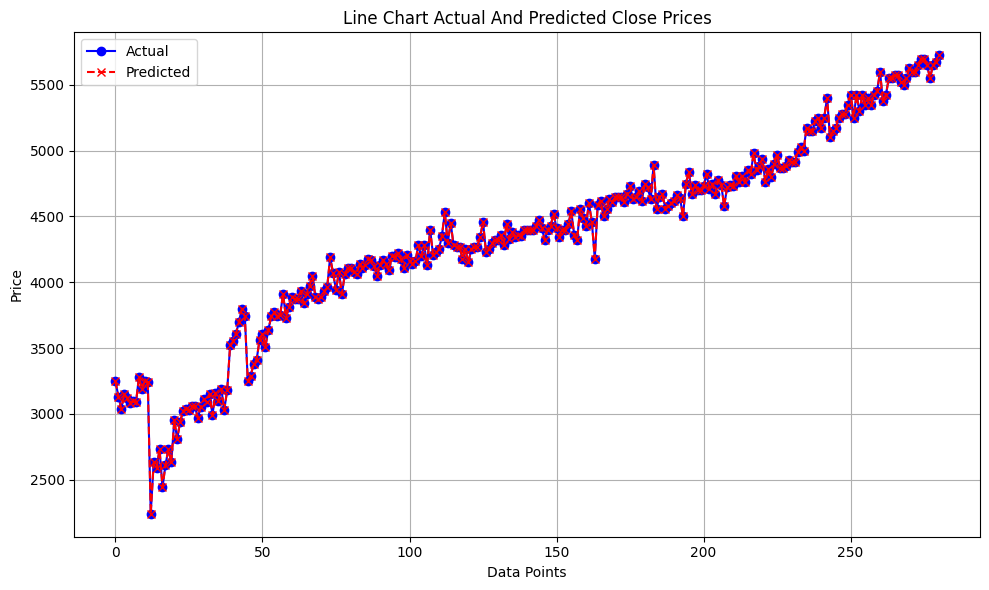

In [34]:
import matplotlib.pyplot as plt
# Mendapatkan prediksi dari test data
predictions = test_predictions.select('prediction').collect()
actual_values = test_data.select('Close').collect()

# Mengonversi hasil prediksi dan nilai aktual ke dalam list
predicted_values = [row['prediction'] for row in predictions]
actual_values_list = [row['Close'] for row in actual_values]

# Membuat line chart
plt.figure(figsize=(10, 6))

# Plot nilai aktual
plt.plot(actual_values_list, label='Actual', marker='o', linestyle='-', color='blue')

# Plot hasil prediksi
plt.plot(predicted_values, label='Predicted', marker='x', linestyle='--', color='red')

# Menambahkan label sumbu x dan y, judul, dan legend
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.title('Line Chart Actual And Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Menampilkan line chart
plt.show()

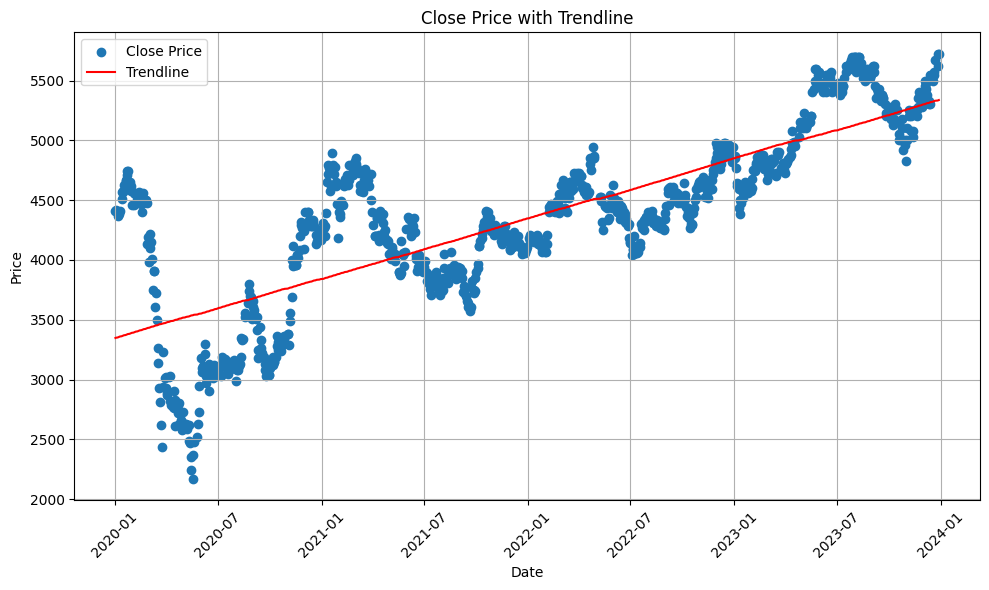

In [36]:
import matplotlib.pyplot as plt
import numpy as np 
from pyspark.sql import functions as F

# Assuming 'date' and 'close' are the respective column names in your Spark DataFrame
data = data.withColumn('date', F.to_date('date', 'yyyy-MM-dd'))

# Convert Spark DataFrame to Pandas DataFrame for visualization
data_pd = data.select('date', 'close').toPandas()

# Sort the data by date if it's not sorted already
data_pd.sort_values('date', inplace=True)

# Extracting x and y values for plotting
x = data_pd['date']
y = data_pd['close']

# Plot the stock price data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Close Price')

# Fit a trendline (linear regression) using numpy.polyfit
z = np.polyfit(x.index.values, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x.index.values), color='red', label='Trendline')

plt.title('Close Price with Trendline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


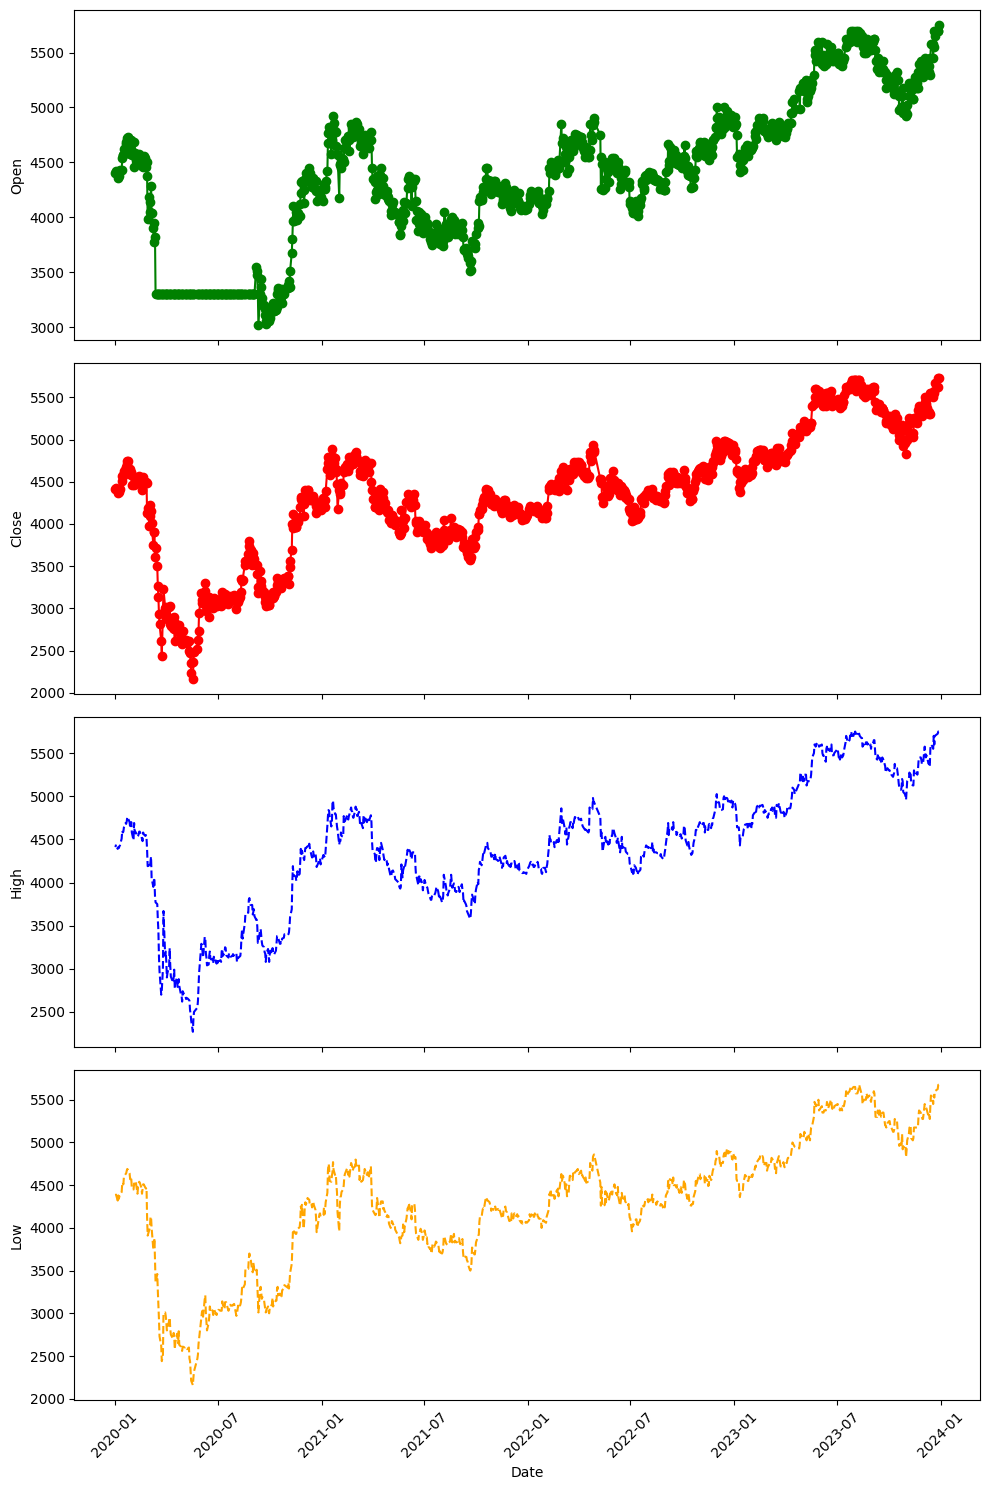

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Mengonversi DataFrame Spark menjadi Pandas DataFrame
pandas_df = data.toPandas()

# Mengatur kolom 'Date' sebagai index dan mengonversi ke tipe datetime
pandas_df['date'] = pd.to_datetime(pandas_df['date'])
pandas_df.set_index('date', inplace=True)

# Membuat candlestick chart menggunakan matplotlib
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15), sharex=True)

# Plotting candlestick chart untuk Open
axes[0].plot(pandas_df.index, pandas_df['Open'], color='green', marker='o', linestyle='-')
axes[0].set_ylabel('Open')

# Plotting candlestick chart untuk Close
axes[1].plot(pandas_df.index, pandas_df['Close'], color='red', marker='o', linestyle='-')
axes[1].set_ylabel('Close')

# Plotting candlestick chart untuk High
axes[2].plot(pandas_df.index, pandas_df['High'], color='blue', linestyle='--')
axes[2].set_ylabel('High')

# Plotting candlestick chart untuk Low
axes[3].plot(pandas_df.index, pandas_df['Low'], color='orange', linestyle='--')
axes[3].set_ylabel('Low')

# Menampilkan chart
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
